# Environment Demo

In [2]:
import sys
import os
import importlib
import numpy as np
import time
import pickle
import json
import neat

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('../'))
import environment 
import utils
importlib.reload(utils), importlib.reload(environment)

(<module 'utils' from '/Users/lorenzoleuzzi/Documents/GitHub/lifelong_evolutionary_swarms/utils.py'>,
 <module 'environment' from '/Users/lorenzoleuzzi/Documents/GitHub/lifelong_evolutionary_swarms/environment.py'>)

## Robot features

- 25 cm diameter
- compass
- 360 vision sensor and object reconition in range 100cm
- comunication between others robots
- ability to pick up stuff (in they're in the same position of the object)
- holonomic motion (every directions)
- maximum velocity: 200 cm/s
- maximum acceleration: 400 cm/s²
- maximum distance covered in a single move: 1/2 acceleration * tstep, 8cm with tstep = 200 ms 

Simulation measurements: everything is divide by the agent size which is reperesented as point in the arena

In [2]:
f"{environment.SIMULATION_ROBOT_SIZE}, {environment.SIMULATION_SENSOR_RANGE}, {environment.TIME_STEP}, {environment.SIMULATION_MAX_WHEEL_VELOCITY}"

'1.0, 4.0, 0.1, 2.0'

We are in a continuous 2D environment (no physics), a robot possesses the capability to navigate in any direction, covering any distance up to a defined maximum per step. Additionally, the robot can pick up and deposit an object objects when is underneath or when it reached an edge, resepctively.

The robots are equipped with sensory equipment capable of identifying nearby entities. A "neighbor" is characterized by a tuple comprising the type of object, the distance to it, and its relative direction. Accordingly, each robot maintains a list of such tuples for a predefined fixed number of neighboring entities.

## Arena

5m x 5m with robots and colored objects 

In [3]:
environment.SIMULATION_ARENA_SIZE 

20.0

## Target
A target color. The robots must pick up the objects of that color and deposit them in right position. The deposit area is in an edge of the arena (top edge).

In [4]:
environment.RED

3

In [5]:
environment.REWARD_PICK, environment.REWARD_DROP

(1, 2)

## Environment initialization

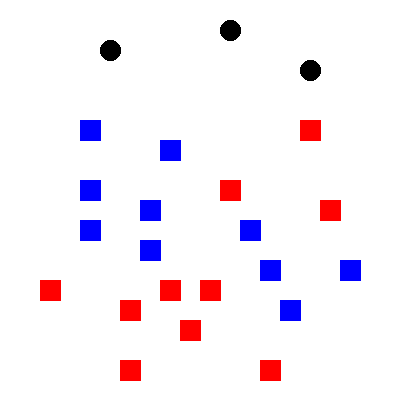

In [23]:
env = environment.SwarmForagingEnv(target_color=environment.RED, 
                                   n_agents=3, 
                                   n_blocks=20,
                                   rate_target_block=0.5, 
                                   blocks_in_line=False, 
                                   colors=[environment.RED, environment.BLUE],)
initial_obs, _ = env.reset() 
env.render(False)

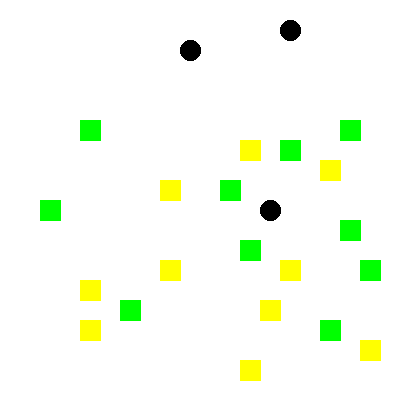

In [22]:
env.agents_location[0] = [10.5,13]
env.render(False)

In [26]:
initial_obs, env.process_observation(initial_obs)

([{'neighbors': array([[  1.        ,   2.40103578,   0.        ],
          [  4.        ,   3.72686668, 164.94588962],
          [  0.        ,   0.        ,   0.        ]]),
   'heading': 189.33015106402848,
   'carrying': -1},
  {'neighbors': array([[1.        , 1.49389036, 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]]),
   'heading': 185.22551343009383,
   'carrying': -1},
  {'neighbors': array([[  1.        ,   2.53573103,   0.        ],
          [  3.        ,   3.46456215, 180.74539056],
          [  0.        ,   0.        ,   0.        ]]),
   'heading': 186.1434262918298,
   'carrying': -1}],
 array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.60025895,  0.93171667,  0.        ,  0.        ,  0.25973115,
          0.        ,  1.    

## Testing

In [83]:
cumulative_reward = 0

In [17]:
action = env.action_space.sample()
next_state, reward, done, _, _ = env.step(action)
next_state

[{'neighbors': array([[  3.        ,   2.21155181, 255.89535391],
         [  3.        ,   2.4103559 , 129.67786323],
         [  4.        ,   2.60538738,  19.16033543]]),
  'heading': 177.7071938612088,
  'carrying': -1},
 {'neighbors': array([[1.       , 2.5935753, 0.       ],
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ]]),
  'heading': 172.15061242794377,
  'carrying': -1},
 {'neighbors': array([[  1.        ,   1.29056828,   0.        ],
         [  1.        ,   3.42703967, 270.        ],
         [  0.        ,   0.        ,   0.        ]]),
  'heading': 176.649275175025,
  'carrying': -1}]

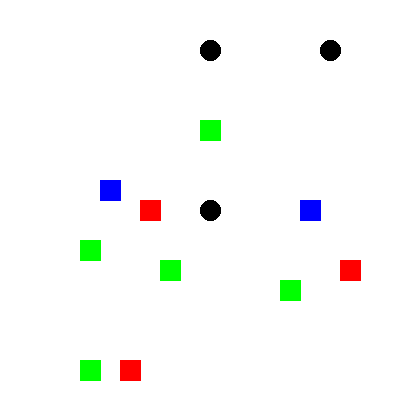

In [84]:
action = env.action_space.sample()
action = [environment.MOVE_RIGHT * np.array([5]), environment.MOVE_RIGHT * np.array([5]), environment.MOVE_RIGHT* np.array([5])]
next_state, reward, done, _, _ = env.step(action)
env.render(False)

## Profiling

about 2000 steps per second

In [19]:
def profile():
    total_time = 0
    for i in range(2000):
        action = env.action_space.sample()
        start = time.time()
        next_state, reward, done, _, _ = env.step(action)
        end = time.time()
        total_time += end - start
    return total_time
profile()

1.1703405380249023

In [20]:
import cProfile
cProfile.run('profile()', sort='cumtime')

         508928 function calls (498928 primitive calls) in 3.044 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.044    3.044 {built-in method builtins.exec}
        1    0.000    0.000    3.044    3.044 <string>:1(<module>)
        1    0.031    0.031    3.044    3.044 1416959497.py:1(profile)
     2000    0.263    0.000    1.856    0.001 environment.py:410(step)
     2000    0.016    0.000    1.148    0.001 tuple.py:87(sample)
     8000    0.024    0.000    1.132    0.000 tuple.py:112(<genexpr>)
     6000    0.387    0.000    1.108    0.000 box.py:184(sample)
51527/41527    0.210    0.000    0.985    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     2000    0.460    0.000    0.560    0.000 environment.py:320(_detect)
     6000    0.232    0.000    0.559    0.000 {method 'uniform' of 'numpy.random._generator.Generator' objects}
     4000    0.009    0.000 

## Load Controller 

In [19]:
# Load a controller
path = f"/Users/lorenzoleuzzi/Library/CloudStorage/OneDrive-UniversityofPisa/lifelong_evolutionary_swarms/results_gecco4/reg_gd_snz_best/diff_lambdas/seed13/static3"
with open(f"{path}/best_genome.pkl", "rb") as f:
    controller = pickle.load(f)
# Set configuration file
with open(f"{path}/neat_config.pkl", "rb") as f:
    config_neat = pickle.load(f)
with open(f"{path}/info.json", "r") as f:
    info_exp = json.load(f)
# load env
# with open(f"{path}/env.pkl", "rb") as f:
#     env = pickle.load(f)
# DOES NOT WORK BECAUSE DIFFERENT VERSIONS OF PYTHON BETWEEN LOCAL AND REMOTE
# load info json
env = environment.SwarmForagingEnv(n_agents = info_exp["n_agents"], n_blocks = info_exp["n_blocks"], colors=[3, 4, 5, 6],
                                   season_colors=[3,4],
                           target_color=3, duration=info_exp["episode_duration"])

In [20]:
net = neat.nn.FeedForwardNetwork.create(controller, config_neat)

In [24]:
env.change_season([5,6], 5)

In [25]:
fitnesses = []
corrects = []
wrongs = []

for i in range(100):
    
    obs, _ = env.reset(seed=None)
    fitness = 0
    
    while True:
        
        nn_inputs = env.process_observation(obs)
        
        nn_outputs = np.array([net.activate(nn_input) for nn_input in nn_inputs])
        actions = (2 * nn_outputs - 1) * env.max_wheel_velocity # Scale output sigmoid in range of wheel velocity

        obs, reward, done, truncated, info = env.step(actions)
        fitness += reward
        if done or truncated:
            print(f"Done: {done}, Truncated: {truncated}, Fitness: {fitness}, correct: {len(info['correct_retrieves'])}, wrong: {len(info['wrong_retrieves'])}")
            break

        # if (env.current_step % 100) == 0:
        #     env.render(True)
    
    fitnesses.append(fitness)
    corrects.append(len(info['correct_retrieves']))
    wrongs.append(len(info['wrong_retrieves']))

print(np.mean(fitnesses), np.mean(corrects), np.mean(wrongs))

Done: False, Truncated: True, Fitness: 26.0, correct: 10, wrong: 4
Done: False, Truncated: True, Fitness: 48.0, correct: 18, wrong: 5
Done: False, Truncated: True, Fitness: 28.0, correct: 11, wrong: 6
Done: False, Truncated: True, Fitness: 47.0, correct: 18, wrong: 7
Done: False, Truncated: True, Fitness: 5.0, correct: 2, wrong: 1
Done: False, Truncated: True, Fitness: 41.0, correct: 16, wrong: 6
Done: False, Truncated: True, Fitness: 35.0, correct: 13, wrong: 4
Done: False, Truncated: True, Fitness: 26.0, correct: 12, wrong: 10
Done: False, Truncated: True, Fitness: 14.0, correct: 6, wrong: 4
Done: False, Truncated: True, Fitness: 20.0, correct: 9, wrong: 6
Done: False, Truncated: True, Fitness: 37.0, correct: 14, wrong: 3
Done: False, Truncated: True, Fitness: 6.0, correct: 4, wrong: 6
Done: False, Truncated: True, Fitness: 20.0, correct: 7, wrong: 1
Done: False, Truncated: True, Fitness: 18.0, correct: 7, wrong: 3
Done: False, Truncated: True, Fitness: 43.0, correct: 15, wrong: 2
Do